In [1]:
import numpy as np
import pandas as pd

pos = pd.read_excel('./data/pos.xls', header=None)
pos['label'] = 1
neg = pd.read_excel('./data/neg.xls', header=None)
neg['label'] = 0
all_ = pos.append(neg, ignore_index=True)

In [51]:
len(pos)

10677

In [50]:
len(neg)

10428

In [7]:
import jieba
all_['words'] = all_[0].apply(lambda s: list(jieba.cut(s))) #调用结巴分词
all_.head()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\DELL\AppData\Local\Temp\jieba.cache
Loading model cost 0.572 seconds.
Prefix dict has been built succesfully.


,0,label,words
0,做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持一...,1,"[做, 父母, 一定, 要, 有, 刘墉, 这样, 的, 心态, ，, 不断, 地, 学习,..."
1,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...,1,"[作者, 真有, 英国人, 严谨, 的, 风格, ，, 提出, 观点, 、, 进行, 论述,..."
2,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...,1,"[作者, 长篇大论, 借用, 详细, 报告, 数据处理, 工作, 和, 计算结果, 支持, ..."
3,作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...,1,"[作者, 在, 战, 几时, 之前, 用, 了, ＂, 拥抱, ＂, 令人, 叫绝, ．, ..."
4,作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...,1,"[作者, 在, 少年, 时即, 喜, 阅读, ，, 能, 看出, 他, 精读, 了, 无数,..."


In [10]:
maxlen = 100 #截断字数
min_count = 5 #出现次数少于该值的词扔掉。这是最简单的降维方法
content = []
for i in all_['words']:
    content.extend(i)

In [11]:
abc = pd.Series(content).value_counts()
abc = abc[abc >= min_count]
abc[:] = list(range(1, len(abc)+1))
abc[''] = 0 #添加空字符串用来补全
word_set = set(abc.index)

In [36]:
def doc2num(s, maxlen): 
    s = [i for i in s if i in word_set]
    #s = s[:maxlen] + ['']*max(0, maxlen-len(s)) #不足maxlen个词的后面补充空格 89%准确率
    s = ['']*max(0, maxlen-len(s)) + s[-maxlen:]  #取后面90%准确率
    return list(abc[s])

In [37]:
all_['doc2num'] = all_['words'].apply(lambda s: doc2num(s, maxlen))

In [39]:
#手动打乱数据
idx = list(range(len(all_)))
np.random.shuffle(idx)
all_ = all_.loc[idx]

In [40]:
#按keras的输入要求来生成数据
x = np.array(list(all_['doc2num']))
y = np.array(list(all_['label']))


In [132]:
import keras
import matplotlib.pyplot as plt
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [152]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding
from keras.layers import LSTM

#建立模型
model = Sequential()
model.add(Embedding(len(abc), 256, input_length=maxlen))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 128
train_num = 15000
history = LossHistory()
his = model.fit(x[:train_num], y[:train_num], batch_size = batch_size, nb_epoch=2, validation_data=(x[train_num:], y[train_num:]),callbacks=[history])
model.evaluate(x[train_num:], y[train_num:], batch_size = batch_size)

D:\ProgramData\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 15000 samples, validate on 6105 samples
Epoch 1/2
15000/15000 [==============================] - 48s 3ms/step - loss: 0.1856 - mean_squared_error: 0.1856 - val_loss: 0.1033 - val_mean_squared_error: 0.1033
Epoch 2/2
6105/6105 [==============================] - 5s 764us/step


[0.08167139836186565, 0.08167139836186565]

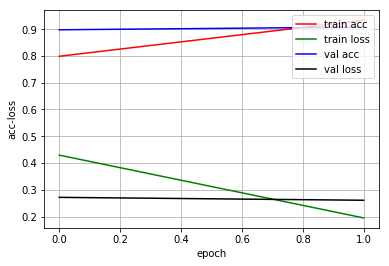

In [148]:
history.loss_plot('epoch')

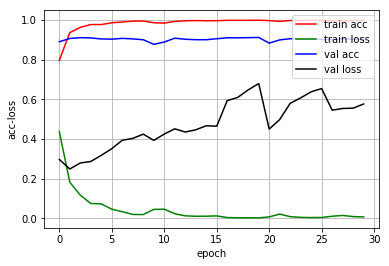

In [146]:
history.loss_plot('epoch')

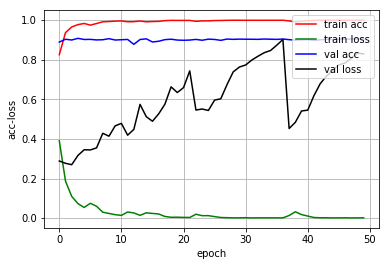

In [137]:
history.loss_plot('epoch')

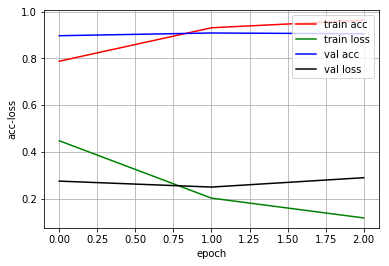

In [142]:
history.loss_plot('epoch')

In [122]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 256)          3666432   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_9 (Activation)    (None, 1)                 0         
Total params: 3,863,681
Trainable params: 3,863,681
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [48]:
#CNN
from keras.layers import Conv1D,GlobalMaxPooling1D

model = Sequential()
model.add(Embedding(len(abc)+1,128,input_length=maxlen))
model.add(Dropout(0.2))
model.add(Conv1D(250,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(250))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x[:train_num], y[:train_num],
          batch_size=16,
          epochs=30,
          validation_data=(x[train_num:], y[train_num:]))
model.evaluate(x[train_num:], y[train_num:], batch_size = 16)

Train on 15000 samples, validate on 6105 samples
Epoch 1/30
15000/15000 [==============================] - 42s 3ms/step - loss: 0.3647 - acc: 0.8355 - val_loss: 0.2394 - val_acc: 0.9075
Epoch 2/30
15000/15000 [==============================] - 41s 3ms/step - loss: 0.1418 - acc: 0.9478 - val_loss: 0.2138 - val_acc: 0.9161
Epoch 3/30
15000/15000 [==============================] - 41s 3ms/step - loss: 0.0523 - acc: 0.9832 - val_loss: 0.2472 - val_acc: 0.9196
Epoch 4/30
15000/15000 [==============================] - 41s 3ms/step - loss: 0.0234 - acc: 0.9927 - val_loss: 0.3106 - val_acc: 0.9191
Epoch 5/30
15000/15000 [==============================] - 41s 3ms/step - loss: 0.0128 - acc: 0.9959 - val_loss: 0.3988 - val_acc: 0.9163
Epoch 6/30
15000/15000 [==============================] - 41s 3ms/step - loss: 0.0149 - acc: 0.9947 - val_loss: 0.4152 - val_acc: 0.9171
Epoch 7/30
15000/15000 [==============================] - 41s 3ms/step - loss: 0.0155 - acc: 0.9950 - val_loss: 0.4090 - val_acc:

[0.8582845116424933, 0.9063063063258328]

In [52]:
def predict_one(s): #单个句子的预测函数
    s = np.array(doc2num(list(jieba.cut(s)), maxlen))
    s = s.reshape((1, s.shape[0]))
    return model.predict_classes(s, verbose=0)[0][0]

In [116]:
predict_one('态度不是非常差')

0

In [58]:
predict_one('苹果手机就是不好用，不像小米手机，漂亮，功能多，屏幕大，还便宜，超级棒')

1

In [86]:
from snownlp import SnowNLP
all_['sentiment'] = all_[0].apply(lambda s: SnowNLP(s).sentiments) #调用结巴分词

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [88]:
def genScore(x):
    if x> 0.5:
        return 1
    else:
        return 0
    
all_['sentiment'] = all_['sentiment'].map(lambda x: genScore(x))

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [107]:
def genResult(x,y):
    if x==y:
        return 1
    else:
        return 0
all_['result'] = all_.apply(lambda row: genResult(row['label'], row['sentiment']), axis=1)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [108]:
res = X_test.result.value_counts()

In [109]:
res

1    5533
0     572
Name: result2, dtype: int64

In [110]:
acc = res[1] / (res[1]+res[0])
print("SnowNlp acc:", acc)

SnowNlp acc: 0.9063063063063063


In [111]:
s = '服务态度好差！'
predict_one(s)

1

In [112]:
pos_prob = SnowNLP(s).sentiments
genScore(pos_prob)

0